# Hate speech

### 1. Data import and error removal

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import ntpath
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
all_files_paths = glob.glob("C:/Users/marti/repos/textsent_project/hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [00:42<00:00, 258.35it/s] 


In [6]:
errors

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>"),
 ('13588794_3',
  "'charmap' codec can't decode byte 0x81 in position 54: character maps to <undefined>"),
 ('13595072_1',
  "'charmap' codec can't decode byte 0x8d in position 75: character maps to <undefined>"),
 ('13595072_5',
  "'charmap' codec can't decode byte 0x8d in position 78: character maps to <undefined>"),
 ('14061724_1',
  "'charmap' codec can't decode byte 0x81 in position 181: character maps to <undefined>"),
 ('14065492_1',
  "'charmap' codec ca

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id", "text"]

In [9]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [10]:
ann = pd.read_csv('C:/Users/marti/repos/textsent_project/hate-speech-dataset/annotations_metadata.csv')

In [11]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [12]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [13]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [14]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

### 2. Cleaning and tokenization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [16]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace('(http\S+)', ' ')\
    .str.replace('(www\S+)',' ')\
    .str.replace(r'com$', ' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')

In [17]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [18]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [ ]:
data.head()

#### 2.3 Bow and Tfidf

In [19]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])

In [ ]:
print(bow_vectorizer.get_feature_names())

In [20]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
print(tfidf_vectorizer.get_feature_names())

['ago', 'also', 'always', 'anyone', 'anything', 'area', 'around', 'back', 'black', 'child', 'come', 'could', 'country', 'day', 'dont', 'even', 'ever', 'every', 'eye', 'find', 'first', 'friend', 'get', 'girl', 'go', 'god', 'going', 'good', 'got', 'great', 'group', 'guy', 'home', 'hope', 'im', 'ireland', 'jew', 'kid', 'know', 'last', 'let', 'like', 'little', 'live', 'long', 'look', 'looking', 'lot', 'make', 'man', 'many', 'maybe', 'much', 'nationalist', 'need', 'negro', 'never', 'new', 'news', 'non', 'nothing', 'old', 'one', 'people', 'place', 'post', 'put', 'race', 'read', 'really', 'right', 'said', 'saw', 'say', 'school', 'see', 'show', 'someone', 'something', 'start', 'take', 'talk', 'thing', 'think', 'thread', 'time', 'two', 'video', 'want', 'watch', 'way', 'week', 'well', 'white', 'woman', 'work', 'world', 'would', 'year', 'youtube']


In [ ]:
pd.DataFrame(X_tfidf[1:11,7:23].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[7:23])

#### 2.4 Top words

In [21]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [22]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [23]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]

In [24]:
mcw # Most common words between lemmatized words and frequencies

,words,freq
0,white,1596
1,like,803
2,people,630
3,black,619
4,one,569
5,get,523
6,would,515
7,youtube,470
8,year,420
9,time,396


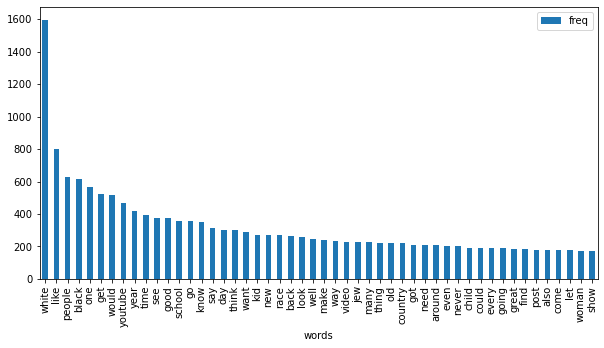

In [25]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

In [26]:
data['tokens'] = data['text_clean'].apply(word_tokenize)

In [ ]:
data.head()

#### 2.5 Part of speech (POS)

In [27]:
# POS
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [28]:
from textblob import TextBlob
TextBlob(data.iloc[4]["text_clean"]).tags

[('click', 'NN'),
 ('download', 'NN'),
 ('mb', 'NN'),
 ('green', 'JJ'),
 ('banner', 'NN'),
 ('link', 'NN')]

In [29]:
TextBlob(data.iloc[4]["stemmed"]).tags

[('click', 'NN'),
 ('download', 'NN'),
 ('mb', 'NN'),
 ('green', 'JJ'),
 ('banner', 'NN'),
 ('link', 'NN')]

In [30]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [31]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

100%|██████████| 10926/10926 [02:23<00:00, 76.13it/s]


In [32]:
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,POS_spacy
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, times, counting]","[(march, PROPN), (booklet, PROPN), (downloaded..."
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklets, downloads, w...","[(order, NOUN), (help, VERB), (increase, VERB)..."
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube...","[(simply, ADV), (copy, VERB), (paste, NOUN), (..."
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,click free download color illustr page e book ...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate...","[(click, VERB), (free, ADJ), (download, NOUN),..."
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...,click download mb green banner link,click download mb green banner link,click download mb green banner link,"[click, download, mb, green, banner, link]","[(click, VERB), (download, PROPN), (mb, PROPN)..."


In [33]:
all_pos = data['POS_spacy'].sum()

In [34]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [35]:
hate = data.loc[data["label"] == 1]

In [36]:
hate.shape[0], data.shape[0] # 1428 over 10926 rows

(1428, 10926)

In [37]:
data.label.value_counts()

0    9498
1    1428
Name: label, dtype: int64

In [38]:
all_pos_hate = hate['POS_spacy'].sum()

In [39]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [40]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [41]:
pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

,index,Freq
0,white,944
1,black,460
2,good,337
3,many,226
4,old,194
5,new,183
6,last,159
7,great,151
8,non,131
9,little,114


In [42]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [43]:
pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

,index,Freq
0,people,624
1,year,387
2,time,367
3,school,274
4,race,256
5,day,231
6,thing,208
7,country,203
8,child,190
9,video,189


In [44]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

In [45]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}

In [46]:
top_noun = {"Total": top_20_noun.keys(), "Freq Total": top_20_noun.values(), "Hate Speech": top_20_noun1.keys(), "Freq Hate Speech": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun

,Total,Freq Total,Hate Speech,Freq Hate Speech
0,people,624,people,105
1,year,387,race,87
2,time,367,country,67
3,school,274,time,48
4,race,256,woman,44
5,day,231,child,41
6,thing,208,thing,41
7,country,203,school,39
8,child,190,way,33
9,video,189,ape,33


In [47]:
common_nouns = list(set(top_noun["Hate Speech"].values).union(set(top_noun["Total"].values)))

In [48]:
freq_common_tot = [noun_counter[x] for x in common_nouns]
freq_common_hate = [noun_counter1[x] for x in common_nouns]

In [49]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq tot": freq_common_tot, "Freq Hate Speech": freq_common_hate })

In [50]:
common_noun_df.sort_values(by=["Freq Hate Speech"], ascending= False, inplace=True)

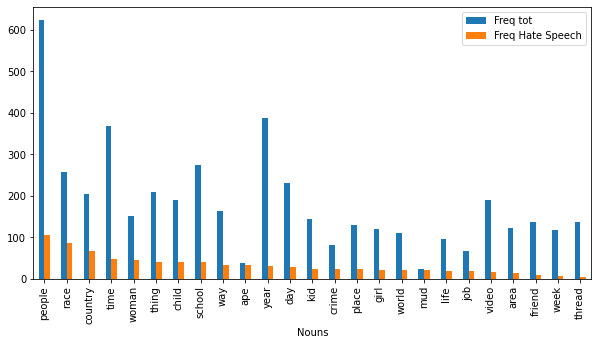

In [51]:
common_noun_df.plot('Nouns', y=['Freq tot', 'Freq Hate Speech'], kind='bar', figsize=(10,5))
plt.show()

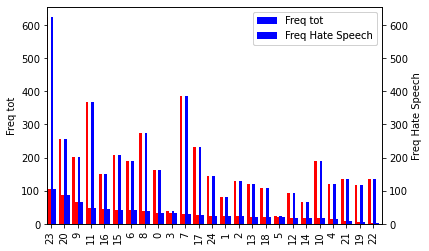

In [52]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

common_noun_df.plot(kind='bar', color='red', ax=ax, width=width, position=1)
common_noun_df.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Freq tot')
ax2.set_ylabel('Freq Hate Speech')

plt.show()

In [53]:
top_adj = {"Total": top_20_adj.keys(), "Freq Total": top_20_adj.values(), "Hate Speech": top_20_adj1.keys(), "Freq Hate Speech": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj

,Total,Freq Total,Hate Speech,Freq Hate Speech
0,white,944,white,259
1,black,460,black,166
2,good,337,non,53
3,many,226,good,40
4,old,194,many,36
5,new,183,last,31
6,last,159,negro,30
7,great,151,little,25
8,non,131,liberal,24
9,little,114,much,21


In [54]:
data[data['text'].str.contains("negro")][:]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,stemmed,lemmatized,tokens,POS_spacy
108,13391410_1,579214,1345,1,1,they act as if negros with aids should have th...,act negros aids right reproduce die way take c...,act negro aid right reproduc die way take care...,act negro aid right reproduce die way take car...,"[act, negros, aids, right, reproduce, die, way...","[(act, VERB), (negro, PROPN), (aid, NOUN), (ri..."
112,13406897_1,579436,1345,0,1,"He's a retarded feral negro ( yes , feral huma...",retarded feral negro yes feral humans cannot t...,retard feral negro ye feral human can not talk...,retarded feral negro yes feral human can not t...,"[retarded, feral, negro, yes, feral, humans, c...","[(retarded, PROPN), (feral, PROPN), (negro, PR..."
114,13406897_3,579436,1345,0,1,I 've seen negroes who look ( and undoubtedly ...,seen negroes look undoubtedly act like,seen negro look undoubtedli act like,seen negro look undoubtedly act like,"[seen, negroes, look, undoubtedly, act, like]","[(seen, VERB), (negro, PROPN), (look, VERB), (..."
230,13503127_1,572147,1345,0,0,Hispanic: A woman threw her 2 1/2-year-old gra...,hispanic woman threw year old granddaughter se...,hispan woman threw year old granddaught sever ...,hispanic woman threw year old granddaughter se...,"[hispanic, woman, threw, year, old, granddaugh...","[(hispanic, ADJ), (woman, NOUN), (threw, VERB)..."
390,14031472_1,596265,1387,2,0,i do this and the looks i get out of disgust a...,looks get disgust regular happily carry walkin...,look get disgust regular happili carri walk la...,look get disgust regular happily carry walking...,"[looks, get, disgust, regular, happily, carry,...","[(look, VERB), (get, AUX), (disgust, VERB), (r..."
...,...,...,...,...,...,...,...,...,...,...,...
9838,12882012_2,577734,1345,0,1,I reported some time ago that negroes will eve...,reported time ago negroes even strip bricks ho...,report time ago negro even strip brick home aw...,reported time ago negro even strip brick home ...,"[reported, time, ago, negroes, even, strip, br...","[(reported, VERB), (time, NOUN), (ago, ADV), (..."
9984,13503418_1,576356,1395,0,1,"Yes, before age of 10 i never saw an negro in ...",yes age never saw negro real life moved hollan...,ye age never saw negro real life move holland ...,yes age never saw negro real life moved hollan...,"[yes, age, never, saw, negro, real, life, move...","[(yes, INTJ), (age, NOUN), (never, ADV), (saw,..."
10397,14413050_1,574116,1375,1,1,Don't stop trying because the negro will prove...,stop trying negro prove right,stop tri negro prove right,stop trying negro prove right,"[stop, trying, negro, prove, right]","[(stop, VERB), (trying, VERB), (negro, ADJ), (..."
10698,30603595_1,573095,1359,3,0,By the way he did n't film the scene for enter...,way n film scene entertainment negro would lie...,way n film scene entertain negro would lie whi...,way n film scene entertainment negro would lie...,"[way, n, film, scene, entertainment, negro, wo...","[(way, PROPN), (n, PROPN), (film, PROPN), (sce..."


In [55]:
common_adj = list(set(top_adj["Hate Speech"].values).union(set(top_adj["Total"].values)))

In [56]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [57]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq tot": freq_common_tot_adj, "Freq Hate Speech": freq_common_hate_adj })

In [58]:
common_adj_df.sort_values(by=["Freq Hate Speech"], ascending= False, inplace=True)

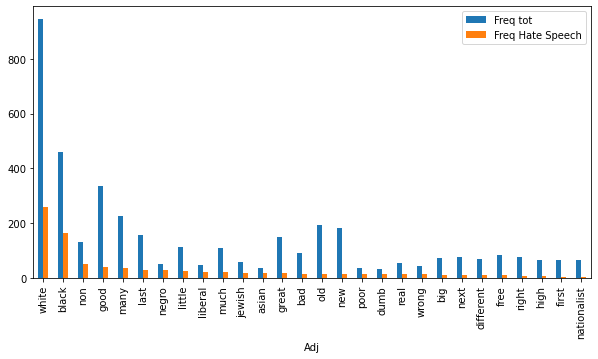

In [59]:
common_adj_df.plot(x='Adj', y=['Freq tot', 'Freq Hate Speech'], kind='bar', figsize=(10,5))
plt.show()

In [60]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_20_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)[:20]}

In [61]:
tpos = pd.DataFrame.from_dict(top_20_pos, orient="index", columns=["Freq"]).reset_index()
tpos

,index,Freq
0,NOUN,26153
1,PROPN,22194
2,VERB,18206
3,ADJ,12077
4,ADV,5369
5,PRON,1167
6,INTJ,1092
7,SCONJ,1004
8,NUM,1000
9,ADP,807


In [62]:
def counter_to_relative(counter):
    total_count = sum(counter.values())
    relative = {}
    for key in counter:
        relative[key] = counter[key] / total_count
    return relative

In [63]:
def relative_frequency(lst, element):
    return lst.count(element) / float(len(lst))

#words = ['apple', 'banana', 'apple', 'orange']
#print(relative_frequency(words, 'apple'))

In [64]:
print(relative_frequency(tpos['index'], 'NOUN'))

KeyError: 'Requested level (NOUN) does not match index name (None)'

In [ ]:
absolute_frequencies_dict = {data['POS_spacy'][1]:data['POS_spacy'][1].count(x) for x in data['POS_spacy'][1]}

In [ ]:
absolute_frequencies_dict = {top_20_pos:top_20_pos.count(x) for x in top_20_pos}

In [65]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_20_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)[:20]}

In [66]:
pd.DataFrame.from_dict(top_20_pos_hate, orient="index", columns=["Freq"]).reset_index()

,index,Freq
0,NOUN,4191
1,PROPN,3472
2,VERB,3083
3,ADJ,2276
4,ADV,891
5,SCONJ,175
6,PRON,157
7,NUM,149
8,INTJ,122
9,ADP,120


In [67]:
top_pos = {"Total": top_20_pos.keys(), "Freq Total": top_20_pos.values(), "Hate Speech": top_20_pos_hate.keys(), "Freq Hate Speech": top_20_pos_hate.values()}
top_pos = pd.DataFrame(top_pos)
top_pos.head()

,Total,Freq Total,Hate Speech,Freq Hate Speech
0,NOUN,26153,NOUN,4191
1,PROPN,22194,PROPN,3472
2,VERB,18206,VERB,3083
3,ADJ,12077,ADJ,2276
4,ADV,5369,ADV,891


#### Sentiment analysis

In [68]:
# Sentiment Analysis by nltk VADER
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_score'] = data['lemmatized'].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))

In [69]:
data.sentiment_score.unique()

array([ 0.    ,  1.345 , -0.0613, ...,  0.7524, -0.1933, -0.2308])

In [70]:
col1 = data['label']
col2 = data['sentiment_score']
correlation_df = col1.corr(col2)
print(correlation_df)

-0.11454004822119156


In [71]:
# RELATION BTW LABEL AND SENTIMETN_SCORE

# SPELLING

In [72]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [73]:
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)

In [74]:
crt = unusual_words(data['lemmatized'])
print(crt)

['africa', 'aragorn', 'asked', 'asking', 'asmodean', 'bb', 'braun', 'btl', 'bugsy', 'calman', 'camie', 'cf', 'cheaper', 'congrats', 'cripppinnn', 'czynski', 'dallas', 'downloads', 'dr', 'dublin', 'ebonics', 'edmonton', 'einherjer', 'embarassing', 'fbi', 'flanative', 'groupid', 'gyspsies', 'haha', 'hahahahahaha', 'heil', 'hups', 'hz', 'ii', 'iii', 'im', 'internet', 'iv', 'kaboom', 'kid', 'kidding', 'kr', 'lk', 'located', 'lol', 'meh', 'minnesota', 'mmm', 'motivated', 'mrbadgersir', 'msciwoj', 'muahaha', 'needed', 'neofolk', 'nigga', 'nordenwulf', 'okay', 'opendocument', 'opps', 'oz', 'patrioticmama', 'pawel', 'pffffft', 'pm', 'politifuldm', 'reproducing', 'rumour', 'ssupreme', 'stormfront', 'studying', 'sveiks', 'swva', 'tereasa', 'tf', 'threadid', 'tnb', 'topix', 'tv', 'twp', 'ty', 'usa', 'vancouver', 'wehrwolf', 'weku', 'whiteutopian', 'wierd', 'wiki', 'wp', 'wpww', 'wrs', 'wulfi', 'wv', 'youtube', 'yuenglings', 'yup', 'zdrowie', 'zoe']


In [75]:
corrected_w =[TextBlob(word).correct().words[0] for word in crt]
corrected_w

['africa',
 'dragoon',
 'asked',
 'asking',
 'asmodean',
 'by',
 'brain',
 'bal',
 'busy',
 'cabman',
 'came',
 'cf',
 'cheaper',
 'congress',
 'cripppinnn',
 'czynski',
 'dallas',
 'download',
 'dr',
 'dublin',
 'tonics',
 'edmonton',
 'einherjer',
 'embarrassing',
 'foi',
 'flanative',
 'grouped',
 'gypsies',
 'hata',
 'hahahahahaha',
 'heal',
 'huts',
 'he',
 'ii',
 'iii',
 'in',
 'internet',
 'iv',
 'boom',
 'kid',
 'bidding',
 'or',
 'll',
 'located',
 'll',
 'me',
 'minnesota',
 'mmm',
 'motivate',
 'mrbadgersir',
 'msciwoj',
 'muahaha',
 'needed',
 'norfolk',
 'night',
 'nordenwulf',
 'okay',
 'opendocument',
 'open',
 'oz',
 'patrioticmama',
 'panel',
 'pffffft',
 'pm',
 'politifuldm',
 'reproducing',
 'rumour',
 'supreme',
 'stormfront',
 'studying',
 'veins',
 'saw',
 'theresa',
 'of',
 'thread',
 'tub',
 'topic',
 'to',
 'two',
 'ty',
 'us',
 'vancouver',
 'wehrwolf',
 'wetu',
 'whiteutopian',
 'wired',
 'wiki',
 'up',
 'www',
 'was',
 'wolf',
 'we',
 'couture',
 'yuenglings

In [76]:
from autocorrect import Speller
def autocorr(text):
    crt = unusual_words(text)
    for t in crt:
        auto = Speller(lang='en')
        corr = auto(t)
        if t != corr:
            print(t, corr)

In [77]:
autocorr(data['lemmatized']) ##

aragorn dragon
btl bl
bugsy bugs
calman salman
camie came
congrats contrast
embarassing embarrassing
groupid grouped
heil heir
hups ups
kaboom boom
neofolk norfolk
nigga nigra
opps apps
pawel panel
pffffft ffffff
ssupreme supreme
stormfront storefront
sveiks speaks
swva swa
tereasa teresa
threadid threaded
tnb nb
topix topic
wehrwolf werewolf
weku wek
wierd weird
wpww www
wulfi multi


In [78]:
# sentiment polarity TEXTBLOB https://textblob.readthedocs.io/en/dev/quickstart.html

# MODELS

In [79]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 13170)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [81]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)

In [82]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)

In [83]:
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')

In [84]:
print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[[2693  157]
 [ 322  106]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2850
           1       0.40      0.25      0.31       428

    accuracy                           0.85      3278
   macro avg       0.65      0.60      0.61      3278
weighted avg       0.83      0.85      0.84      3278

0.8538743136058572


In [85]:
# Support Vector Machine
svc = SVC(verbose=10)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)

[LibSVM]

In [86]:
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')

In [87]:
print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

[[2847    3]
 [ 407   21]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       0.88      0.05      0.09       428

    accuracy                           0.87      3278
   macro avg       0.87      0.52      0.51      3278
weighted avg       0.87      0.87      0.82      3278

0.8749237339841367


In [88]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)

In [89]:
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')

In [121]:
print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))

[[324 105]
 [138 290]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       429
           1       0.73      0.68      0.70       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.72       857
weighted avg       0.72      0.72      0.72       857

0.7164527421236873


In [90]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)

In [91]:
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')

In [92]:
print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

[[2815   35]
 [ 380   48]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2850
           1       0.58      0.11      0.19       428

    accuracy                           0.87      3278
   macro avg       0.73      0.55      0.56      3278
weighted avg       0.84      0.87      0.83      3278

0.87339841366687


In [93]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=10)
NN.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN = NN.predict(X_test)

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [94]:
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')

In [95]:
print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))

[[2737  113]
 [ 311  117]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2850
           1       0.51      0.27      0.36       428

    accuracy                           0.87      3278
   macro avg       0.70      0.62      0.64      3278
weighted avg       0.85      0.87      0.85      3278

0.8706528370957901


In [96]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)

In [97]:
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')

In [98]:
print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))

[[2609  241]
 [ 274  154]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2850
           1       0.39      0.36      0.37       428

    accuracy                           0.84      3278
   macro avg       0.65      0.64      0.64      3278
weighted avg       0.84      0.84      0.84      3278

0.8428920073215376


In [99]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

In [100]:
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')

In [101]:
print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

[[2850    0]
 [ 420    8]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       1.00      0.02      0.04       428

    accuracy                           0.87      3278
   macro avg       0.94      0.51      0.48      3278
weighted avg       0.89      0.87      0.81      3278

0.8718730933496034


In [102]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.853874,0.403042,0.596288,0.612565
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.875229,0.743590,0.532124,0.528513
Random Forest,0.873398,0.578313,0.549934,0.559608
Neural Networks,0.870653,0.508696,0.616858,0.641867
Decision Tree,0.842892,0.389873,0.637626,0.642205
K-Nearest Neighbors,0.871873,1.000000,0.509346,0.484035


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

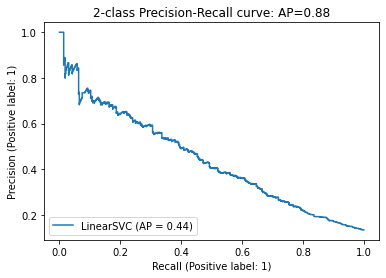

In [103]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(prec_svc))

In [104]:
## ONLY

# Imbalanced

In [106]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [107]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy='majority')

In [108]:
X_over, y_over = undersample.fit_resample(X_class, y_class)

In [111]:
from collections import Counter
print(Counter(y_over))

Counter({0: 1428, 1: 1428})


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)

In [132]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[[268 161]
 [119 309]]
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       429
           1       0.66      0.72      0.69       428

    accuracy                           0.67       857
   macro avg       0.67      0.67      0.67       857
weighted avg       0.67      0.67      0.67       857

0.6732788798133023


In [134]:
# Support Vector Machine
svc_i = SVC(verbose=10)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))

[LibSVM][[325 104]
 [136 292]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       429
           1       0.74      0.68      0.71       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.72       857
weighted avg       0.72      0.72      0.72       857

0.7199533255542591


In [135]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))

[[324 105]
 [138 290]]
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       429
           1       0.73      0.68      0.70       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.72       857
weighted avg       0.72      0.72      0.72       857

0.7164527421236873


In [136]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

[[333  96]
 [177 251]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       429
           1       0.72      0.59      0.65       428

    accuracy                           0.68       857
   macro avg       0.69      0.68      0.68       857
weighted avg       0.69      0.68      0.68       857

0.6814469078179697


In [137]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=10)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))

[[306 123]
 [128 300]]
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       429
           1       0.71      0.70      0.71       428

    accuracy                           0.71       857
   macro avg       0.71      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7071178529754959


C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [138]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
tree_i = DecisionTreeClassifier()
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))

[[279 150]
 [160 268]]
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       429
           1       0.64      0.63      0.63       428

    accuracy                           0.64       857
   macro avg       0.64      0.64      0.64       857
weighted avg       0.64      0.64      0.64       857

0.6382730455075846


In [139]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

[[427   2]
 [415  13]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       429
           1       0.87      0.03      0.06       428

    accuracy                           0.51       857
   macro avg       0.69      0.51      0.37       857
weighted avg       0.69      0.51      0.37       857

0.5134189031505251


In [141]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)

,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.673279,0.657447,0.673336,0.672529
Support Vector Machine,0.719953,0.737374,0.719909,0.719537
Logistic Regression,0.716453,0.734177,0.716407,0.716006
Random Forest,0.681447,0.723343,0.681336,0.678504
Neural Networks,0.707118,0.709220,0.707111,0.707103
Decision Tree,0.638273,0.641148,0.635942,0.638213
K-Nearest Neighbors,0.513419,0.866667,0.512856,0.365301
